In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from collections import namedtuple
from fuel.datasets.hdf5 import H5PYDataset


BATH_SIZE = 100
IMG_SIZE = 256

# Img resizing stuff
LR_HR_RATIO = 4
BIG_SIZE = int(IMG_SIZE * 76 / 64)
SMALL_SIZE = int(BIG_SIZE / LR_HR_RATIO)

DATA_TEMPLATE =             '/fashion/ssense_%i_%i.h5'
LANGUAGE_MODEL_FILE =       '/data/glove/glove.6B.300d.txt'
LANGUAGE_MODEL_VOCABULARY = '/data/glove/glove.6B.vocab'

OUTPUT =                    '/data/classes_and_texts.txt'
OUTPUT_JSON =               '/data/categories.json'

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
data_set = H5PYDataset(DATA_TEMPLATE % (IMG_SIZE, IMG_SIZE), which_sets=('all',))

In [4]:
def list_keys(data_set): 
    return [k.split('_')[1] for k in sorted(data_set.axis_labels.keys())]

In [11]:
for i, key in enumerate(list_keys(data_set)):
    print("%d %s" % (i, key))

0 brand
1 category
2 composition
3 department
4 description
5 gender
6 image
7 msrpUSD
8 name
9 productID
10 season
11 subcategory


In [12]:
Item = namedtuple('Item', ' '.join(list_keys(data_set)))

In [13]:
import string
from collections import Counter

BLACK_LIST = string.punctuation.replace('%', '') + '\n'

def normalize(text_array, 
    black_list = BLACK_LIST, 
    vocab=None, lowercase =  True, tokenize = False):
    text = text_array[0]
    if black_list:
        text = text.translate(None, BLACK_LIST)
    if lowercase:
        text = text.lower()
    if vocab:
        text = ' '.join([word for word in text.split() if word in vocab])
    if tokenize:
        return text.split()
    return text

In [14]:
def dump_for_keras(
    data_set, output, 
    batch_size = BATH_SIZE, limit=None, vocab=None):
    '''
    Dumps the hdf5 dataset to flat textfile
    '''
    N = data_set.num_examples
    num_batch = N / batch_size + 1
    
    handle = data_set.open()
    with open(output, 'wr') as f:
        processed = 0
        for i in itertools.islice(xrange(num_batch), limit):
            # fetch batch of data
            low, high = i*batch_size, min((i+1)*batch_size, data_set.num_examples)
            rows = data_set.get_data(handle, slice(low, high))
            
            # process batch
            classes = [row[0].replace(" ", "_") for row in rows[1]]
            texts = [normalize(text, vocab=vocab) for text in rows[4]]
            lines = ["%s %s\n" % (c, t) for c,t in zip(classes, texts)]
            # dumplines
            f.writelines(lines)
             
            if i % 100 == 0:
                percent = int(((100.0 * i )/ num_batch))
                print("Low: %d, high: %d" % (low, high))
                print("Processing %i batch out of %i [%i processed]" % (i, num_batch, processed))
            
            # track progress 
            processed += len(texts)  

## Some sanity checks

In [17]:
import itertools
import math

tokens = Counter()
classes = Counter()
ids = set()

handle = data_set.open()
num_batch = data_set.num_examples / BATH_SIZE + 1
for i in xrange(num_batch):
    if i % 100 == 0:
        percent = int(((100.0 * i )/ num_batch))
        print("Processing %i batch out of %i [%i percent]" % (i, num_batch, percent))
        print("Number of tokens in the dictionary: %i" % len(tokens))
        print("Number of classes in the dictionary: %i" % len(classes))
    
    low, high = i*BATH_SIZE, min((i+1)*BATH_SIZE, data_set.num_examples)
    rows = data_set.get_data(handle, slice(low, high))
    
    tokens.update(itertools.chain(*[
        normalize(text[0], tokenize=True) for text in rows[4]
    ]))
    classes.update(itertools.chain([
        row[0] for row in rows[1]
    ]))
    ids.update([x[0] for x in rows[9]])

Processing 0 batch out of 738 [0 percent]
Number of tokens in the dictionary: 0
Number of classes in the dictionary: 0
Processing 100 batch out of 738 [13 percent]
Number of tokens in the dictionary: 24
Number of classes in the dictionary: 20
Processing 200 batch out of 738 [27 percent]
Number of tokens in the dictionary: 25
Number of classes in the dictionary: 25
Processing 300 batch out of 738 [40 percent]
Number of tokens in the dictionary: 26
Number of classes in the dictionary: 44
Processing 400 batch out of 738 [54 percent]
Number of tokens in the dictionary: 27
Number of classes in the dictionary: 48
Processing 500 batch out of 738 [67 percent]
Number of tokens in the dictionary: 27
Number of classes in the dictionary: 49
Processing 600 batch out of 738 [81 percent]
Number of tokens in the dictionary: 27
Number of classes in the dictionary: 49
Processing 700 batch out of 738 [94 percent]
Number of tokens in the dictionary: 27
Number of classes in the dictionary: 49


In [18]:
print("There are %s distinct words in the dataset" % len(tokens))
print("There are %s distinct classes in the dataset" % len(classes))
print("There are %s distinct ids in the dataset" % len(ids))

There are 27 distinct words in the dataset
There are 49 distinct classes in the dataset
There are 73761 distinct ids in the dataset


In [19]:
tokens.most_common(10)

[('l', 30661),
 ('s', 22579),
 ('r', 3696),
 ('c', 2053),
 ('h', 1696),
 ('w', 1557),
 ('t', 1476),
 ('b', 1438),
 ('m', 1273),
 ('p', 1195)]

# Are we missing something?

In [20]:
with open(LANGUAGE_MODEL_FILE, 'rt') as f:
    vocab = set([line.split(" ")[0] for line in f.readlines()])

In [21]:
missing_words = Counter({ word: tokens[word] for word in tokens if word.lower() not in vocab})
print("There are %i missing words out of %i" % (len(missing_words), len(tokens)))
print("Most common mising words")
missing_words.most_common(10)

There are 1 missing words out of 27
Most common mising words


[('\x91', 1)]

# Sample data

In [25]:
import scipy.misc
import random

def clean_plot(img):
    plt.imshow(img); plt.xticks([]); plt.yticks([]); plt.show()
    
def clean_plot_dpi(img, size, dpi=60):
    plt.figure().set_size_inches(float(size)/float(dpi),float(size)/float(dpi))
    plt.xticks([]); plt.yticks([]);
    plt.imshow(img);

In [42]:
i = random.randint(0, data_set.num_examples)
item = Item._make(data_set.get_data(handle, slice(i, min((i+1), data_set.num_examples))))

Raw text: 
Long sleeve lightweight sweater in black. Alternating knit and sheer paneling throughout. Ribbed crewneck collar, cuffs, and hem. Tonal stitching.

Normalized text: 
long sleeve lightweight sweater in black alternating knit and sheer paneling throughout ribbed crewneck collar cuffs and hem tonal stitching

Normalized text with vocab: 
long sleeve lightweight sweater in black alternating knit and sheer paneling throughout ribbed crewneck collar cuffs and hem tonal stitching



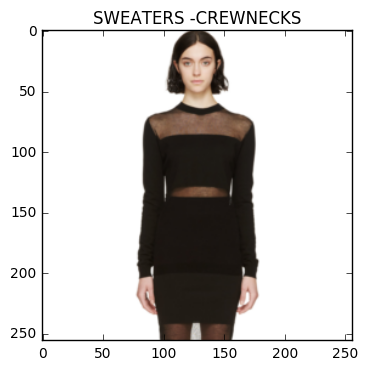

In [44]:
plt.title("%s -%s" % (item.category[0][0], item.subcategory[0][0]))
plt.imshow(item.image[0]);
print("Raw text: \n%s\n" % item.description[0][0])
print("Normalized text: \n%s\n" %  ' '.join(
    normalize(item.description[0], tokenize=True)))
print("Normalized text with vocab: \n%s\n" %  ' '.join(
    normalize(item.description[0], vocab=vocab, tokenize=True)))
plt.show()

## To be consistent with StackGAN

In [181]:
img = item.image[0]
img_76 = scipy.misc.imresize(img, [SMALL_SIZE, SMALL_SIZE], 'bicubic')
img_304 = scipy.misc.imresize(img, [BIG_SIZE, BIG_SIZE], 'bicubic')

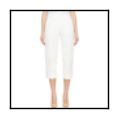

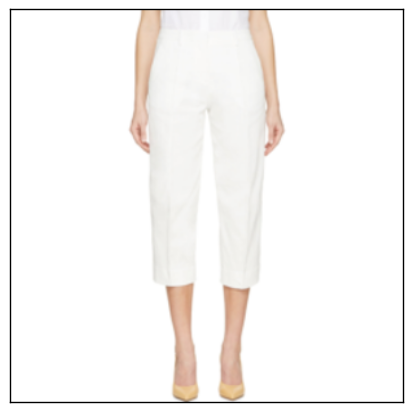

In [182]:
clean_plot_dpi(img_76, SMALL_SIZE); clean_plot_dpi(img_304, BIG_SIZE);

# Dump data for text embedding with CNN

In [ ]:
dump_for_keras(data_set, OUTPUT, batch_size = BATH_SIZE, vocab=None)

# Dump categories

In [255]:
import json

with open(OUTPUT_JSON, 'wt') as f:
    category2idx = {key.replace("&", "AND") : idx for idx, (key, count) in enumerate(classes.most_common(), 1)}
    f.write(json.dumps(category2idx))

## Load data

In [65]:
with open(OUTPUT, 'rt') as f:
    classes, texts = zip(*[line.split(" ", 1) for line in f.readlines()])

In [66]:
c = Counter([len(t.split(' ')) for t in texts])

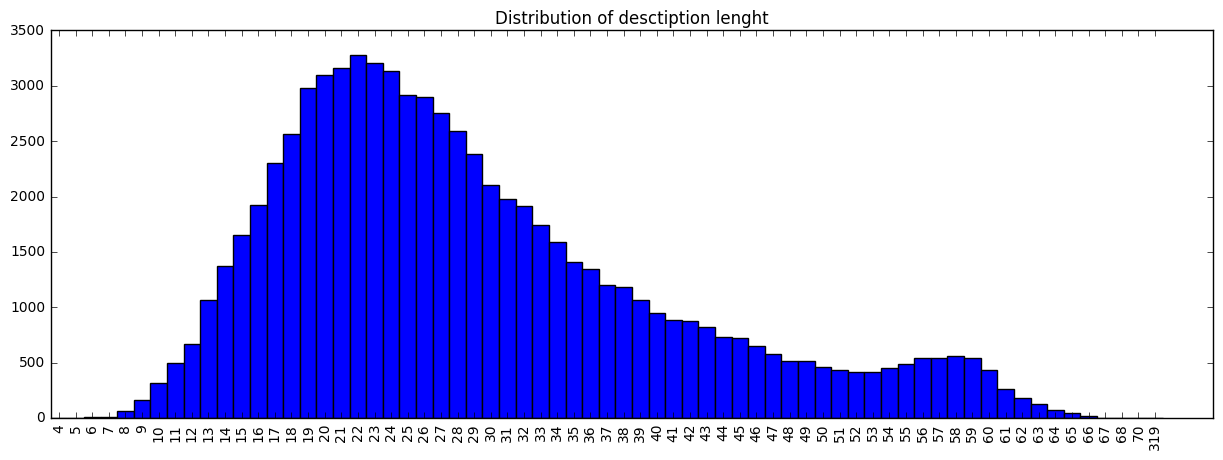

In [213]:
labels, values = zip(*c.items())

indexes = np.arange(len(labels))
width = 1

plt.figure(figsize=(15, 5))
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels, rotation=90)
plt.title('Distribution of description lenght')
plt.show()

## Classes

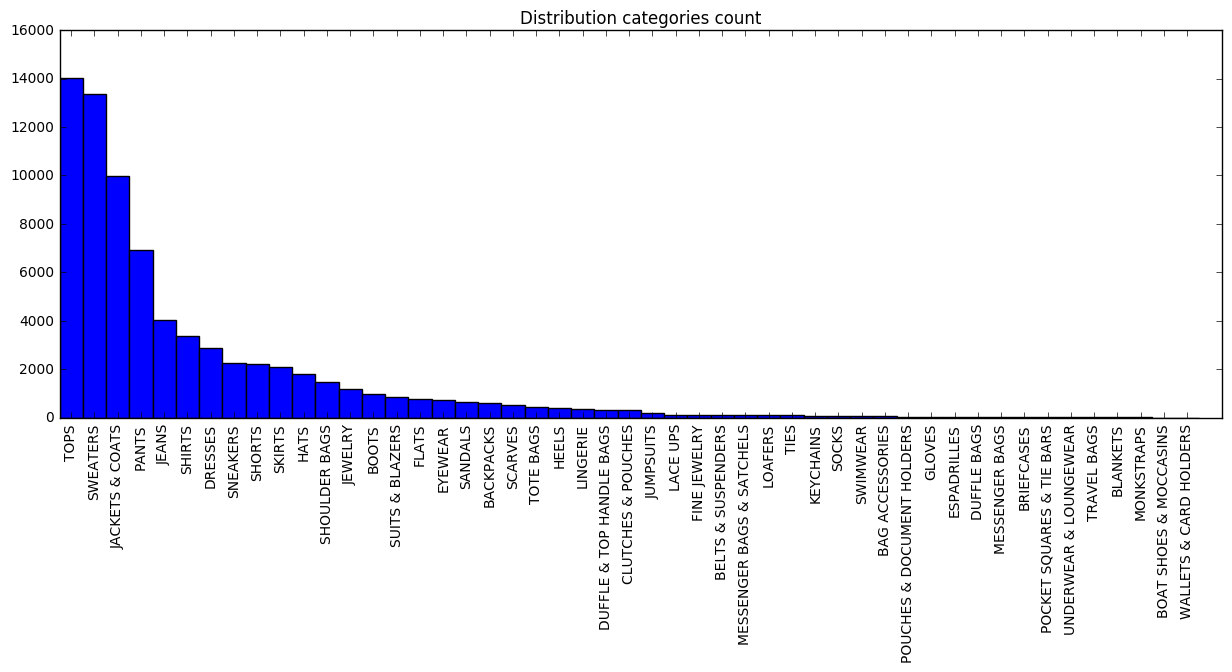

In [214]:
class_counts = Counter(classes)
labels, values = zip(*class_counts.most_common())

indexes = np.arange(len(labels))
width = 1

plt.figure(figsize=(15, 5))
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels, rotation=90)
plt.title('Distribution categories count')
plt.show()

In [146]:
import os
import sys
import logging

In [83]:
sys.path.append(os.path.abspath('../'))

In [261]:
from embedding.utils import plot_splits
from embedding.train_embedding_model import load_and_process, train_val_split

In [265]:
data, labels, tokenizer = load_and_process('/data/classes_and_texts.txt', 10000, 70, True)

2018-03-05 21:06:28,713 [INFO] Class statistics
2018-03-05 21:06:28,715 [INFO] Found 49 classes
2018-03-05 21:06:28,716 [INFO] 	 TOPS: 14040
2018-03-05 21:06:28,717 [INFO] 	 SWEATERS: 13355
2018-03-05 21:06:28,718 [INFO] 	 JACKETS_&_COATS: 9991
2018-03-05 21:06:28,719 [INFO] 	 PANTS: 6914
2018-03-05 21:06:28,720 [INFO] 	 JEANS: 4029
2018-03-05 21:06:28,721 [INFO] 	 SHIRTS: 3357
2018-03-05 21:06:28,723 [INFO] 	 DRESSES: 2852
2018-03-05 21:06:28,724 [INFO] 	 SNEAKERS: 2237
2018-03-05 21:06:28,725 [INFO] 	 SHORTS: 2200
2018-03-05 21:06:28,726 [INFO] 	 SKIRTS: 2108
2018-03-05 21:06:28,727 [INFO] 	 HATS: 1790
2018-03-05 21:06:28,728 [INFO] 	 SHOULDER_BAGS: 1456
2018-03-05 21:06:28,729 [INFO] 	 JEWELRY: 1181
2018-03-05 21:06:28,730 [INFO] 	 BOOTS: 964
2018-03-05 21:06:28,731 [INFO] 	 SUITS_&_BLAZERS: 869
2018-03-05 21:06:28,732 [INFO] 	 FLATS: 780
2018-03-05 21:06:28,733 [INFO] 	 EYEWEAR: 739
2018-03-05 21:06:28,734 [INFO] 	 SANDALS: 658
2018-03-05 21:06:28,735 [INFO] 	 BACKPACKS: 610
2018-0

In [273]:
x_train, y_train, x_val, y_val = train_val_split(data, labels, 0.1, seed=1)

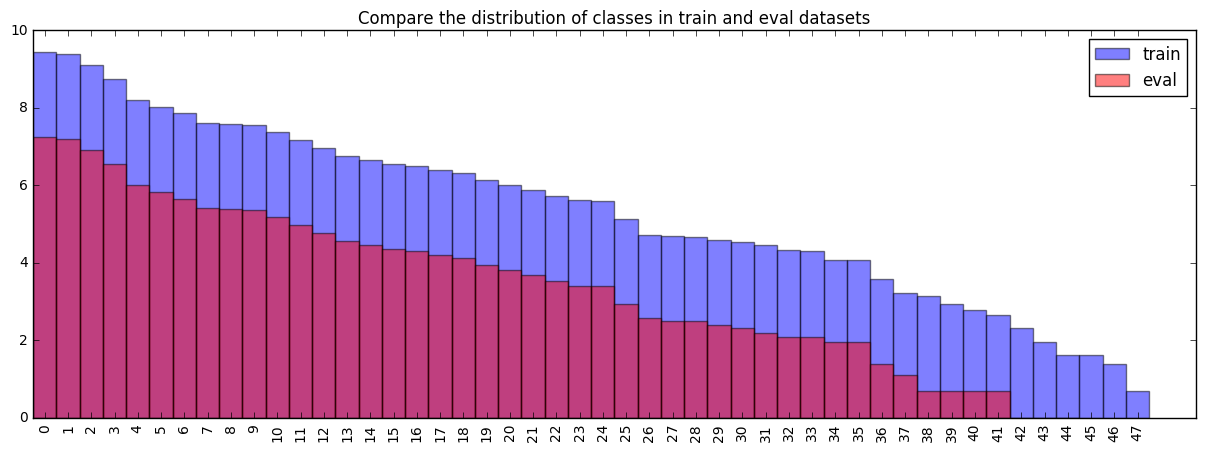

In [274]:
plot_splits(
    train_classes = np.argmax(y_train, axis=1),
    test_classes  = np.argmax(y_val, axis=1)
)

In [251]:
# Sanity check for the distribution of classes
errors = []
for a, b in zip(values_v, values_t):
    a_norm, b_norm = a/ (1.0 * sum(values_v)), b/(1.0*sum(values_t))
    errors.append((a_norm - b_norm)**2)
    #print("%0.4f, %0.4f" % (a_norm, b_norm))

print("MSE: %0.5f" % (sum(errors)/len(errors)))

MSE: 0.00000
